In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_spectra(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for y in arr:
                yield {"x": x, "y": y}
        except KeyError:
            return

In [3]:
df = pd.read_excel("n2_levels.xlsx")
df.head()

,config,level (cm−1),level (nm),level (eV),level,energy (eV),n*,line widths,jet absorption,ab initio,ref
0,b'(18),116209.0,86.051855,14.408079,0.529483,-1.172921,3.405820,sharp band,0.452,0.39,1
1,b'(19),116684.5,85.701186,14.467034,0.531650,-1.113966,3.494782,sharp band,1.310,1.58,1
2,3pσ(6),116810.2,85.608962,14.482618,0.532222,-1.098382,3.519488,sharp band,1.170,1.12,1
3,b'(20),117206.7,85.319355,14.531778,0.534029,-1.049222,3.600994,sharp band,1.180,1.45,1
4,b'(21),117684.1,84.973246,14.590968,0.536204,-0.990032,3.707076,broad band,0.565,0.55,1


In [4]:
runs = [212]
globbed = chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed) if is_available(fn))
it = chain.from_iterable(read_spectra(fn) for fn in filenames)

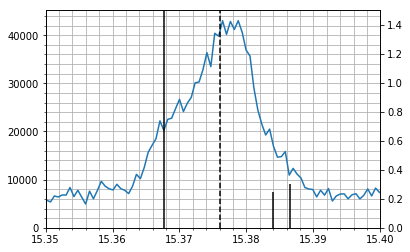

In [5]:
# %matplotlib notebook
%matplotlib inline

d = next(it)
offset = -0.005
plt.plot(1239.84193 / d["x"] - offset, d["y"])
plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which='both')
plt.axvline(15.376 , linestyle='--', color='k')

plt.twinx()
plt.vlines(df["level (eV)"], 0, df["jet absorption"])
plt.xlim(15.35, 15.4)
plt.ylim(0, 1.5)
plt.show()